In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import gamma

def nano(num):
    return num * 10**(-9)

# Brownian motion equations:

**note:** This notebook works in meters and does not consider pixel size

Movement changes in different directions:
$$\Delta x_i \sim N(0, sd = \sqrt{2 \cdot D_i \cdot \Delta t}) $$
$$\Delta y_i \sim N(0, sd = \sqrt{2 \cdot D_i \cdot \Delta t}) $$
$$\Delta z_i \sim N(0, sd = \sqrt{2 \cdot D_i \cdot \Delta t}) $$
 - $\Delta t$ = time step
 - D = diffusion coefficient

How that relates to mean squared displacement: from crocker grier:
$$ (|r(t + \tau) - r(t)|^2) = 2 \cdot d \cdot D \cdot \tau$$
 - d = number of dimensions
 - $\tau$ = time interval
 - D = diffusion coefficient

Diffusion coefficient equation:
$$D_i = \frac{k_B T}{6 \pi \eta r_i} $$
- $D_i$ = diffusion coefficient
- $k_B$ = Bolzman's constant ($1.380649 × 10^{-23}$)
- $T$ = temperature (Kelvin)
- $\eta$ = dynamic viscosity
- $r_i$ = particle radius





# 2d simulation case

#### previous student's stokes-einstein code

(modified to return D instead of sigma)

In [2]:
def stokes_einstein(r, t, T_Kelvin, eta):
    # Boltzmann's constant
    k_B = 1.38e-23

    # Calculate diffusion coefficient using Stokes-Einstein relation
    D = (k_B * T_Kelvin) / (6 * np.pi * eta * r)
    
    return D

#### Code to run simulation

In [3]:
# from test data
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

num_particles = 10
num_frames = 100

# generate particle radiuses
radii = np.linspace(nano(50), nano(150), num_particles)
#radii = np.random.normal(nano(100), nano(10), num_particles)

# generate diffusion coefficients
Ds = stokes_einstein(radii, t, T_Kelvin, eta)
# calculate sigmas
variance = 2 * Ds * t
sigmas = np.sqrt(variance)

# create initial positions
positions = np.zeros((num_frames, num_particles, 2))
# have all particles start at origin for now


# do wiener step process
for frame in range(1, num_frames):
    # from previous group:
    move = np.column_stack((np.random.normal(0, sigmas, num_particles), 
                                 np.random.normal(0, sigmas, num_particles)))
    positions[frame] = positions[frame - 1] + move

    

#### Code to plot simulation

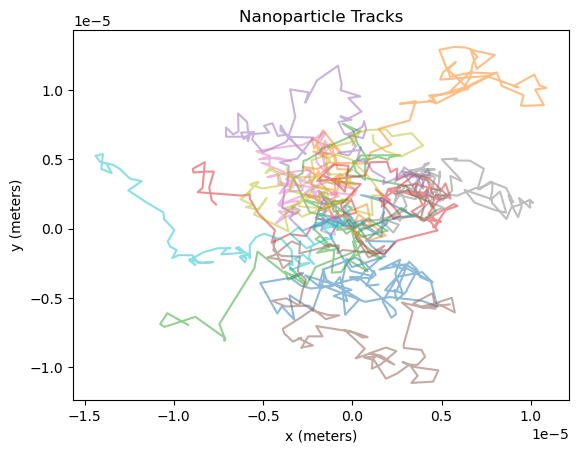

In [4]:
def plot_2d_particles(positions, particle_inds="all", alpha=0.5):
    num_particles = positions.shape[1]
    
    if particle_inds == "all":
        for i in range(num_particles):
            plt.plot(positions[:, i, 0], positions[:, i, 1], alpha=alpha)
        
        plt.xlabel("x (meters)")
        plt.ylabel("y (meters)")
        plt.title("Nanoparticle Tracks")
        
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        for i in particle_inds:
            plt.plot(positions[:, i, 0], positions[:, i, 1], alpha=alpha)
        
        plt.xlabel("x (meters)")
        plt.ylabel("y (meters)")
        plt.title("Nanoparticle Tracks (filtered)")
        
        plt.show()
        

#plot_2d_particles(positions, particle_inds=[0], alpha=1)
plot_2d_particles(positions)

# 2d Bayesian postierior equation case

In Bayesian statistics, the likelihood function is defined as $L(param | data) = P(data | param)$

We can use our known equations of $\Delta x_i \sim N(0, \sigma^2 = 2 \cdot D_i \cdot \Delta t)$ and 
$\Delta y_i \sim N(0, \sigma^2 = 2 \cdot D_i \cdot \Delta t)$ to create a likelihood for $r_i$

$$ $$

Since $\Delta x_i$ and $\Delta y_i$ are iid, we will treat them as observations from the same distribution, which gives use twice the sample size.



$$ $$

Now let use define the precision as $\tau = \frac{1}{\sigma^2}$. If we attempt to solve this by estimating the precision $\tau$, we can treat this as a Bayesian problem of a normal distribution with known precision. This gives us the following Bayesian equations: ($\Gamma$ = Gamma distribution)

$$\text{Prior}(\tau) = \Gamma(\alpha, \beta)$$
$$\text{Posterior}(\tau | x_1, x_2, \dots, x_n) = \Gamma\left(\alpha + \frac{n}{2}, \beta + \frac{\sum^n_{i=1} (x_i - \mu)^2}{2}\right) $$

Wikipedia conjugates page: https://en.wikipedia.org/wiki/Conjugate_prior

$$ $$

For our case, we can treat all parameters other than radius as constant, which gives us the variance:
$$ \sigma^2 = 2 \cdot D_i \cdot \Delta t = 2 \cdot \frac{k_B T}{6 \pi \eta r_i} \cdot \Delta t = \frac{C}{r_i} \qquad \text{ where } C = \frac{k_B T \Delta t}{3 \pi \eta}$$

Likewise, this gives use the precision:
$$\tau = \frac{r_i}{C} \qquad \text{ where } C = \frac{k_B T \Delta t}{3 \pi \eta} $$


$$ $$

With this, we get out precision posterior:

$$\text{Posterior}(\frac{r_i}{C}| \Delta x_1, \Delta y_1, \Delta x_2, \Delta y_2, \dots, \Delta x_n, \Delta y_n) = \Gamma\left(\alpha + n, \beta + \frac{\sum^n_{i=1} (\Delta x_i)^2 + \sum^n_{i=1} (\Delta y_i)^2}{2}\right) $$


When can then use this property of Gamma distributions:
$$\text{if } X \sim \Gamma(\alpha, \beta), \text{then for constant } C \text{, we have: } CX \sim \Gamma\left(\alpha, \frac{\beta}{C}\right)$$

This gives us our final posterior distribution for $r_i$:
$$\text{Posterior}(r_i | \Delta x_1, \Delta y_1, \Delta x_2, \Delta y_2, \dots, \Delta x_n, \Delta y_n) = \Gamma\left(\alpha + n, \frac{1}{C} \cdot \left(\beta + \frac{\sum^n_{i=1} (\Delta x_i)^2 + \sum^n_{i=1} (\Delta y_i)^2}{2}\right)\right) $$


#### code for 2d ground truth movement inference

The code fits a prior gamma distribution to our known values for $\tau$ and then calculates the posterior for each particle based on their movement in the positions array

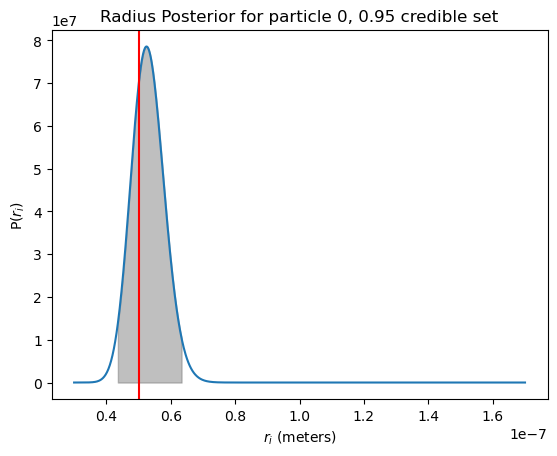

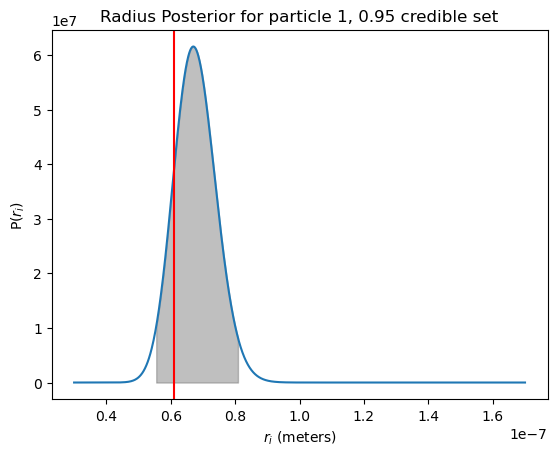

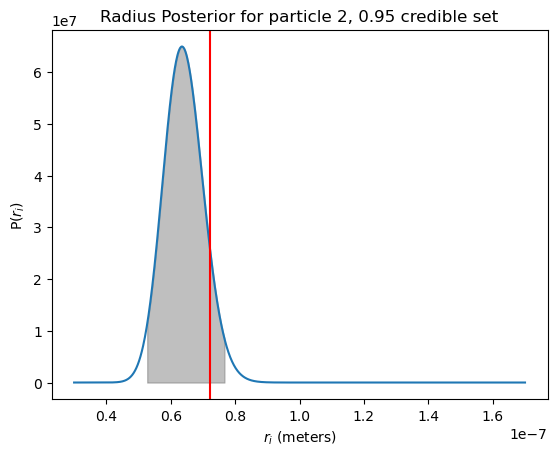

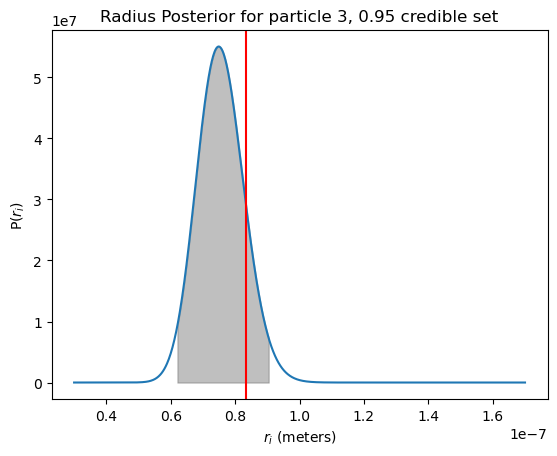

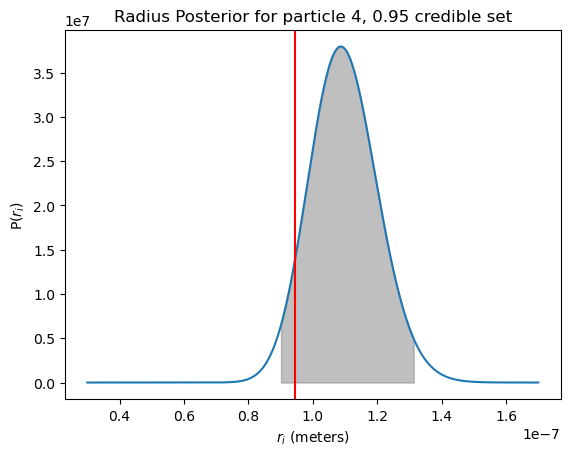

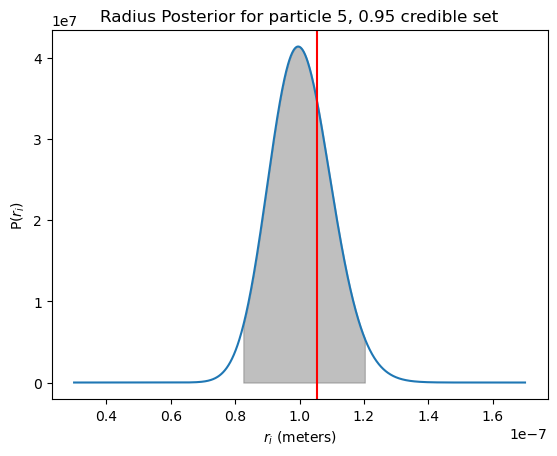

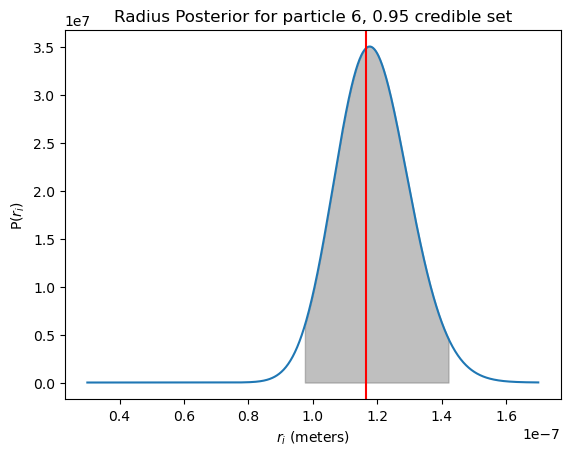

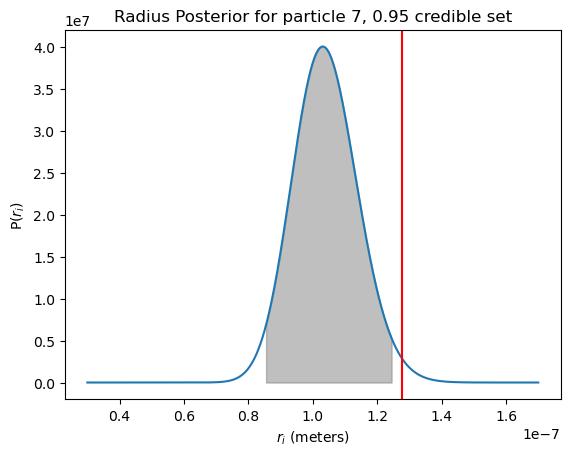

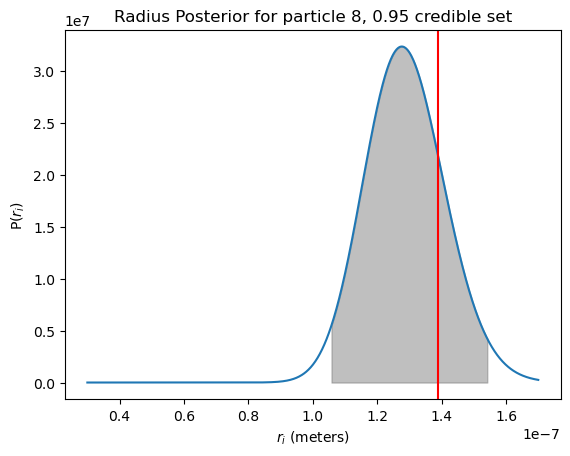

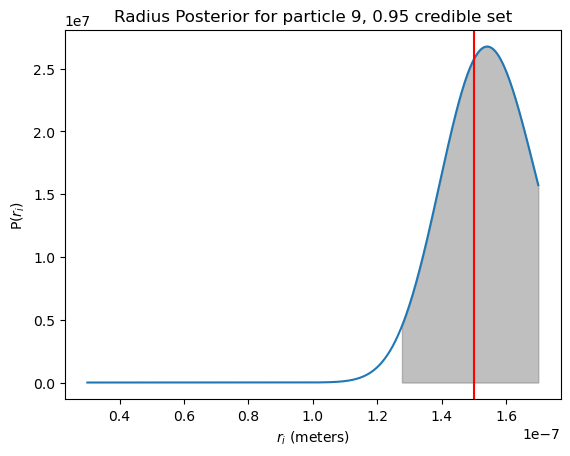

In [5]:
credible_percentage = 0.95

# calculate C
k_B = 1.38e-23

C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)


# use radii to calculate list of precisions
tau_s = radii / C


# fit gamma distribution to the precisions list
# this will be used as our overall tau prior
shape, loc, scale = stats.gamma.fit(tau_s, floc=0)

prior_alpha = shape
prior_beta = 1 / scale

#print("Prior alpha:", prior_alpha, " prior beta:", prior_beta)

# run through inference for each particle
for i in range(num_particles):
    # get x and y positions
    x_pos = positions[:, i, 0]
    y_pos = positions[:, i, 1]

    # calculate movement by differences between positions
    x_dist = np.diff(x_pos)
    y_dist = np.diff(y_pos)

    # square all the distance movements
    x_dist_sqd = np.square(x_dist)
    y_dist_sqd = np.square(y_dist)

    # concatenate distances into one array
    dist_sqd_array = np.concatenate((x_dist_sqd, y_dist_sqd))
    
    # calculate posterior alpha and beta
    num_dists = len(dist_sqd_array)
    posterior_alpha = prior_alpha + (num_dists / 2)
    
    posterior_beta = (prior_beta + (sum(dist_sqd_array) / 2)) / C
    
    
    # get true radius
    true_radius = radii[i]


    # Plot posterior and true value

    # calculate gamma curve for posterior
    plot_x = np.linspace(nano(30), nano(170), 1000)
    plot_y = gamma.pdf(plot_x, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Plot posterior gamma curve
    plt.plot(plot_x, plot_y)
    
    # Add red line for true radius
    plt.axvline(true_radius, color='r')


    # calculate credible set
    tail = (1 - credible_percentage) / 2
    lower_bound = gamma.ppf(tail, a=posterior_alpha, scale= 1 / posterior_beta)
    upper_bound = gamma.ppf(1 - tail, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Shade credible set
    plt.fill_between(plot_x, plot_y, where=(plot_x >= lower_bound) & (plot_x <= upper_bound), color='gray', alpha=0.5)
    
    
    plt.title(f"Radius Posterior for particle {i}, {credible_percentage} credible set")
    plt.xlabel("$r_i$ (meters)")
    plt.ylabel("P($r_i$)")
    
    plt.show()



# 3d simulation case

#### Code to run simulation

Same as before but with one extra dimension now

In [6]:
# from test data
t = 0.1 # 100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

num_particles = 10
num_frames = 100

# generate particle radiuses
radii = np.linspace(nano(50), nano(150), num_particles)
#radii = np.random.normal(nano(100), nano(10), num_particles)

# generate diffusion coefficients
Ds = stokes_einstein(radii, t, T_Kelvin, eta)
# calculate sigmas
variance = 2 * Ds * t
sigmas = np.sqrt(variance)

# create initial positions
positions = np.zeros((num_frames, num_particles, 3))
# have all particles start at origin for now


# do wiener step process
for frame in range(1, num_frames):
    # from previous group:
    move = np.column_stack((np.random.normal(0, sigmas, num_particles), 
                                 np.random.normal(0, sigmas, num_particles), np.random.normal(0, sigmas, num_particles)))
    positions[frame] = positions[frame - 1] + move

#### Code to plot simulation

Since this is 3d, I'm not going to worry about plotting the simulation

# 3d Bayesian postierior equation case

Since we have the ground truth of $\Delta z_i$, we can also treat it as iid with $\Delta x_i$ and $\Delta y_i$. So we will treat all x, y, and z movements as coming from the same distribution of $N(0, \sigma^2 = 2 \cdot D_i \cdot \Delta t)$, giving us three times the sample size.


Since the math should be the same, I'll skip to the final posterior equation:

If $\text{Prior}(\tau = \frac{r_i}{C}) = \Gamma(\alpha, \beta)$, then:

$$\text{Posterior}(r_i | \Delta x_1, \Delta y_1, \Delta z_1, \Delta x_2, \Delta y_2, \Delta z_2, \dots, \Delta x_n, \Delta y_n, \Delta z_n) = \Gamma\left(\alpha + 1.5 \cdot n, \frac{1}{C} \cdot \left(\beta + \frac{\sum^n_{i=1} ((\Delta x_i)^2 + (\Delta y_i)^2 + (\Delta z_i)^2)}{2}\right)\right) $$

where $C = \frac{k_B T \Delta t}{3 \pi \eta}$


#### code for 3d ground truth movement inference

The code fits a prior gamma distribution to our known values for $\tau$ and then calculates the posterior for each particle based on their movement in the positions array

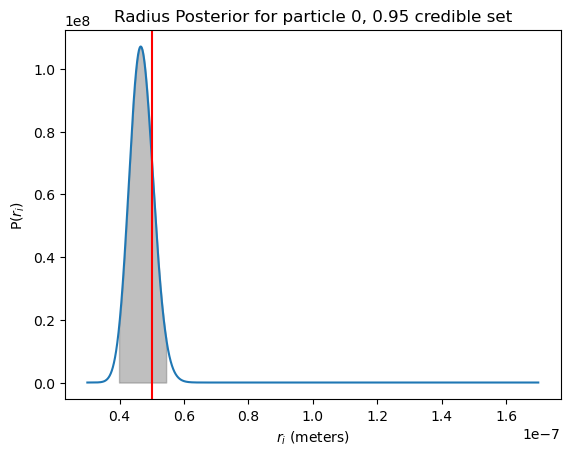

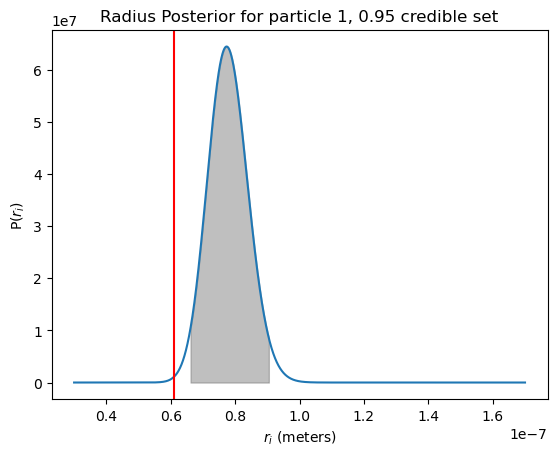

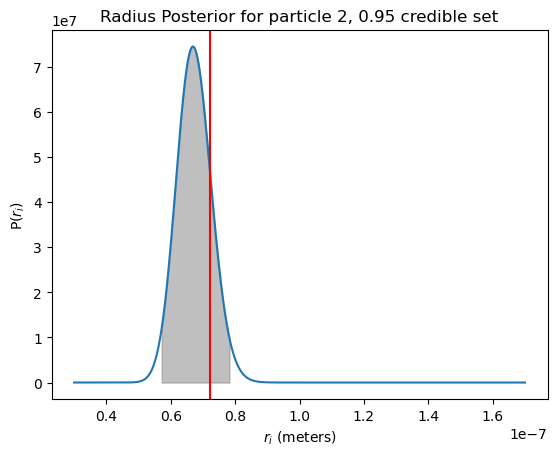

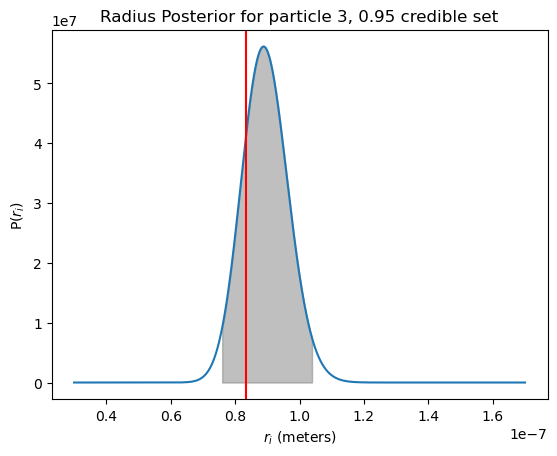

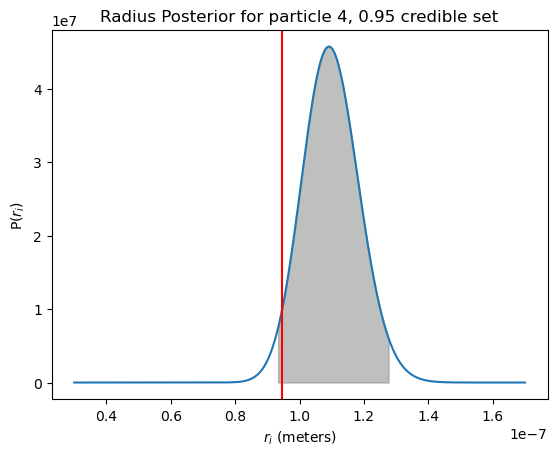

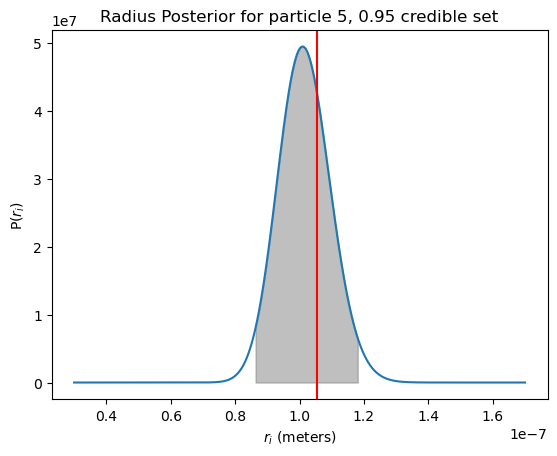

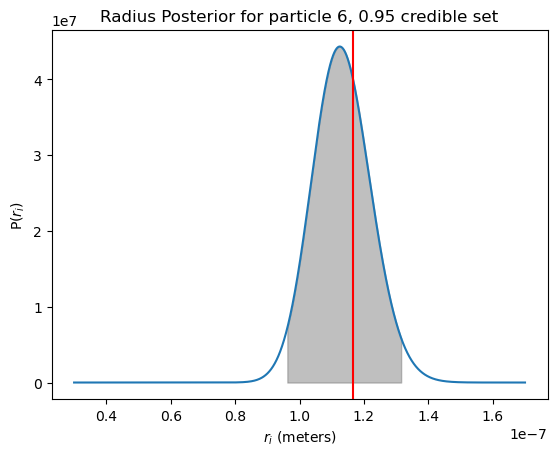

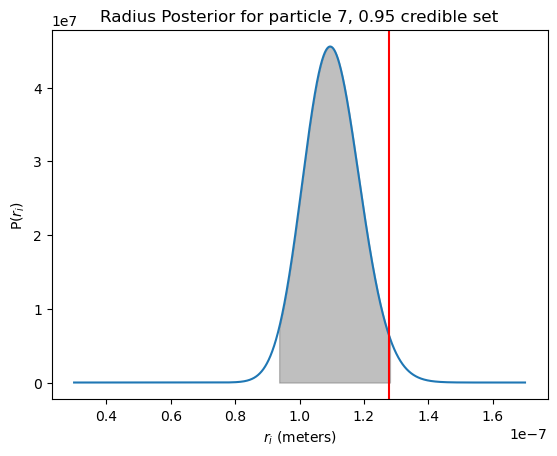

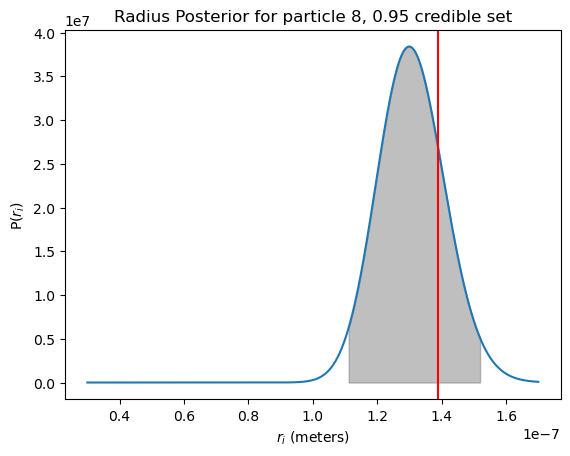

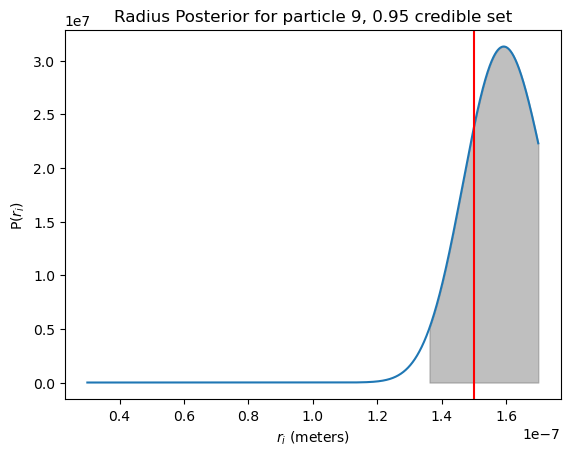

In [7]:
credible_percentage = 0.95

# calculate C
k_B = 1.38e-23

C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)


# use radii to calculate list of precisions
tau_s = radii / C


# fit gamma distribution to the precisions list
# this will be used as our overall tau prior
shape, loc, scale = stats.gamma.fit(tau_s, floc=0)

prior_alpha = shape
prior_beta = 1 / scale

#print("Prior alpha:", prior_alpha, " prior beta:", prior_beta)

# run through inference for each particle
for i in range(num_particles):
    # get x, y, and z positions
    x_pos = positions[:, i, 0]
    y_pos = positions[:, i, 1]
    z_pos = positions[:, i, 2]

    # calculate movement by differences between positions
    x_dist = np.diff(x_pos)
    y_dist = np.diff(y_pos)
    z_dist = np.diff(y_pos)

    # square all the distance movements
    x_dist_sqd = np.square(x_dist)
    y_dist_sqd = np.square(y_dist)
    z_dist_sqd = np.square(z_dist)

    # concatenate distances into one array
    dist_sqd_array = np.concatenate((x_dist_sqd, y_dist_sqd, z_dist_sqd))
    
    # calculate posterior alpha and beta
    num_dists = len(dist_sqd_array)
    posterior_alpha = prior_alpha + (num_dists / 2)
    
    posterior_beta = (prior_beta + (sum(dist_sqd_array) / 2)) / C
    
    # get true radius
    true_radius = radii[i]


    # Plot posterior and true value

    # calculate gamma curve for posterior
    plot_x = np.linspace(nano(30), nano(170), 10000)
    plot_y = gamma.pdf(plot_x, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Plot posterior gamma curve
    plt.plot(plot_x, plot_y)
    
    # Add red line for true radius
    plt.axvline(true_radius, color='r')


    # calculate credible set
    tail = (1 - credible_percentage) / 2
    lower_bound = gamma.ppf(tail, a=posterior_alpha, scale= 1 / posterior_beta)
    upper_bound = gamma.ppf(1 - tail, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Shade credible set
    plt.fill_between(plot_x, plot_y, where=(plot_x >= lower_bound) & (plot_x <= upper_bound), color='gray', alpha=0.5)

    
    plt.title(f"Radius Posterior for particle {i}, {credible_percentage} credible set")
    plt.xlabel("$r_i$ (meters)")
    plt.ylabel("P($r_i$)")
    
    plt.show()

Divider section

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$
$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$
$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Issue of Brightness Uncertainty
